# prepare test data

In [188]:
from PIL import Image
import glob
import random
from torchvision.transforms import ToTensor
import torch
import numpy as np
import matplotlib.pyplot as plt
from detector_nets import get_detector

In [189]:
# real_ims_p = random.sample(glob.glob('../TR-Net/20211220_liuchi/detection/detection_dataset/test/real/progan-*'), 200)
# progan_ims_p = [i.replace('real', 'fake') for i in real_ims_p]
real_ims_p = random.sample(glob.glob('./test_results/unet/before/*real*.png'), 200)
progan_ims_p = random.sample(glob.glob('./test_results/unet/before/*mmdgan*.png'), 200)

In [190]:
def load_ims(ims):
    tt = ToTensor()
    data = np.asarray([np.array(Image.open(i)) for i in ims])
    return data, torch.from_numpy(np.transpose(data, (0,3,1,2)))

In [191]:
real_ims, real_ims_torch = load_ims(real_ims_p)
progan_ims, progan_ims_torch = load_ims(progan_ims_p)

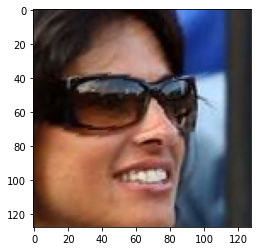

In [192]:
plt.imshow(real_ims[0])


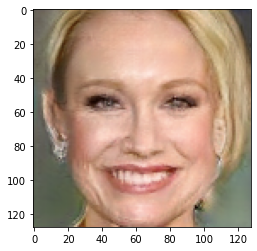

In [193]:
plt.imshow(progan_ims[0])

# high frequency exchange

In [194]:
# def circular_mask(shape = (128,128,3), thre = 30):
#     h, w, _ = shape
#     Y, X = np.ogrid[:h, :w]
#     center = (int(w / 2), int(h / 2))
#     dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
#     mask = dist_from_center <= thre
#     return np.dstack([mask, mask, mask])

# def hfe(source, target, thre):
#     mask = circular_mask(thre=thre)
    
#     s_fre = np.fft.fft2(source, axes=(0, 1))
#     s_fre_shift = np.fft.fftshift(s_fre)
#     s_low_fre = s_fre_shift * mask
#     s_high_fre = s_fre_shift * (1 - mask)
    
#     t_fre = np.fft.fft2(target, axes=(0, 1))
#     t_fre_shift = np.fft.fftshift(t_fre)
#     t_low_fre = t_fre_shift * mask
#     t_high_fre = t_fre_shift * (1 - mask)
    
#     t_exchange_fre = t_low_fre + s_high_fre
#     # t_exchange_fre = t_low_fre
#     t_exchange_im = np.abs(np.fft.ifft2(np.fft.ifftshift(t_exchange_fre), axes=(0, 1)))
#     view = np.clip(t_exchange_im, 0, 255)
#     view = view.astype('uint8')
#     return t_exchange_im, view
from transformations import FrequencyExchange

In [195]:
att_ims = np.asarray([FrequencyExchange(random.sample([i for i in real_ims],2),j,40)() for j in progan_ims])
print(att_ims.shape)

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

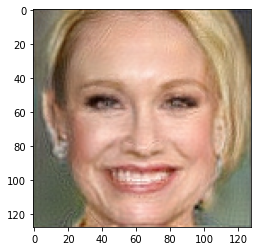

In [196]:
plt.imshow(att_ims[0])

In [197]:
att_ims_torch = torch.from_numpy(np.transpose(att_ims, (0,3,1,2)))
print(att_ims_torch.shape)

torch.Size([200, 3, 128, 128])


# check spectral distribution

In [198]:
from utils import psd_loss
SD = psd_loss.PSDLoss(128,128)

In [199]:
real_ims_torch = real_ims_torch.to('cuda:0')
progan_ims_torch = progan_ims_torch.to('cuda:0')
att_ims_torch = att_ims_torch.to('cuda:0')

In [200]:
real_sd = SD.spectral_vector(real_ims_torch).cpu().numpy()
progan_sd = SD.spectral_vector(progan_ims_torch).cpu().numpy()
att_sd = SD.spectral_vector(att_ims_torch).cpu().numpy()


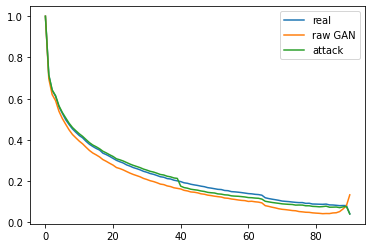

In [201]:
plt.plot(real_sd.mean(0), label='real')
plt.plot(progan_sd.mean(0), label='raw GAN')
plt.plot(att_sd.mean(0),label='attack')
plt.legend()

# prediction results

In [202]:
torch.cuda.empty_cache()

In [203]:
det_model = get_detector('xception').to('cuda:0')
det_model.load_state_dict(torch.load('./det_outputs/train_on_attack/x128-xception-aug-0-stgan-rgb/best.pth'))

<All keys matched successfully>

In [204]:
tt = ToTensor()

In [205]:
with torch.no_grad():
    det_model.eval()
    real_ims_tensor = torch.stack([tt(i) for i in real_ims]).to('cuda:0')
    real_pred = torch.max(det_model(real_ims_tensor),1)

In [206]:
real_pred

torch.return_types.max(
values=tensor([3.6198, 3.8993, 4.2545, 3.2889, 4.1143, 4.4494, 4.0901, 4.2571, 4.3749,
        3.7871, 4.3379, 4.5474, 4.2727, 4.2012, 3.9960, 4.1842, 4.4336, 4.3093,
        4.0556, 2.0833, 4.5174, 4.3919, 4.4507, 4.4876, 3.5203, 4.3511, 4.0783,
        2.0861, 3.3820, 4.1345, 4.4334, 4.4157, 3.9323, 4.5014, 1.0852, 4.2113,
        4.2915, 3.6392, 3.8510, 4.3473, 4.1434, 4.1320, 3.9959, 4.4431, 4.2922,
        4.1247, 4.2043, 4.4091, 4.2494, 2.7950, 4.5345, 4.1008, 2.9530, 4.5579,
        4.5201, 1.9678, 4.0460, 4.0769, 4.3745, 1.3541, 3.5160, 4.2604, 4.2317,
        3.2540, 4.3662, 3.8088, 4.3491, 3.8953, 3.4632, 4.4828, 3.4468, 4.3021,
        4.6112, 1.0169, 4.3742, 4.3360, 4.2006, 4.2585, 3.9771, 4.1679, 4.5052,
        4.4169, 4.3577, 4.2571, 4.1761, 3.6834, 4.5155, 2.9139, 3.4446, 0.4345,
        4.2349, 3.7450, 0.2462, 1.6942, 4.0861, 4.3718, 4.3061, 3.2763, 4.4547,
        4.0561, 4.2576, 4.3272, 3.5333, 4.0634, 4.2122, 4.5114, 3.2422, 4.3991,
        3

In [207]:
with torch.no_grad():
    det_model.eval()
    progan_ims_tensor = torch.stack([tt(i) for i in progan_ims]).to('cuda:0')
    progan_pred = torch.max(det_model(progan_ims_tensor),1)

In [208]:
progan_pred

torch.return_types.max(
values=tensor([ 3.0386,  2.5498,  4.5769,  0.7130,  3.6396,  0.7295, 10.3209,  5.2788,
         5.2755,  4.0938,  3.5257,  4.8508,  5.9665,  2.2158,  3.1300,  5.0540,
         3.4007,  4.7224,  3.3293,  5.7400,  2.8521,  3.9070,  2.0919,  4.5424,
         3.5721,  1.4920,  0.5629,  0.3803,  2.0120,  4.1422,  2.6727,  0.1156,
         3.9691,  3.3510,  1.9106,  7.5608,  3.1794,  4.3287,  0.9801,  2.0210,
         2.7105,  4.5304,  0.4767,  4.0586,  4.1915,  5.5714,  1.5982,  3.3799,
         2.7119,  4.2308,  2.0778,  1.4800,  4.2558,  3.5023,  3.3642,  3.7728,
         0.7184,  0.8761,  4.8659,  1.3142,  0.8406,  3.6233,  5.2436,  5.5572,
         5.1782,  4.9614,  2.5210,  0.1578,  3.6501,  1.5270,  4.8979,  0.0592,
         1.8767,  2.7067,  2.4055,  0.1261,  5.5265,  0.7005,  5.0725,  3.0839,
         1.4837,  0.5046,  3.9521,  1.9310,  2.8058,  2.7618,  3.7030,  3.1965,
         4.2600,  2.4290,  5.4030,  3.5813,  3.7159,  3.5592,  2.0664,  1.7024,
         

In [209]:
with torch.no_grad():
    det_model.eval()
    att_ims_tensor = torch.stack([tt(i) for i in att_ims]).to('cuda:0')
    att_pred = torch.max(det_model(att_ims_tensor),1)

In [210]:
att_pred

torch.return_types.max(
values=tensor([2.0481, 4.4570, 3.8824, 1.7129, 2.4262, 2.4126, 8.7407, 3.9487, 5.7816,
        4.0940, 1.3648, 4.2289, 5.6927, 3.3071, 0.4935, 4.2697, 3.4897, 3.5067,
        1.9684, 5.1688, 3.6398, 3.9144, 3.0192, 3.4922, 4.5789, 3.4121, 3.2502,
        1.7810, 0.4501, 4.4339, 1.3789, 0.4015, 2.8325, 4.6787, 0.2329, 6.9691,
        2.4148, 4.9954, 0.4537, 2.7887, 2.3827, 5.1979, 0.5865, 3.6358, 4.6201,
        5.5004, 1.0378, 0.8267, 3.2096, 4.5855, 3.8116, 1.6597, 2.9977, 4.0501,
        2.2973, 4.5142, 2.9809, 0.0985, 3.9682, 0.1080, 3.5501, 2.9569, 4.8718,
        5.0779, 6.1300, 5.6943, 1.9514, 3.3501, 2.0073, 3.0938, 4.1952, 2.2853,
        3.4035, 0.5339, 2.6443, 2.5975, 4.4689, 2.2351, 3.7880, 1.6710, 0.0172,
        3.1563, 3.4338, 1.9309, 2.7459, 3.4773, 3.6893, 2.8154, 2.9240, 2.4852,
        2.5817, 0.0124, 2.4060, 2.7572, 2.2494, 2.9707, 4.4444, 6.2429, 0.2446,
        1.7500, 3.1174, 2.9931, 4.0698, 3.6069, 1.5545, 3.7481, 4.2749, 3.5636,
        4

In [211]:
sum(att_pred[1])

tensor(156, device='cuda:0')

In [212]:
sum(progan_pred[1])

tensor(164, device='cuda:0')

In [213]:
from metrics import psnr, ssim, lfd

In [214]:
psnr(progan_ims, att_ims)

28.72136239966675

In [215]:
np.mean([ssim(progan_ims[i], att_ims[i]) for i in range(len(progan_ims))])

0.8578340001916714